# Function Approximation (1) 
## Tile Coding in the Mountain Car problem

In this notebook we will show benefits of FA in the Mountain Car problem

The Goal of Mountain Car problem is to reach the top of a hill when the obvious solution of accelerating does not work when starting form the bottom of the valley.

https://gym.openai.com/envs/MountainCar-v0/

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0")

[2018-04-12 18:01:49,008] Making new env: MountainCar-v0


From the previous notebook, we can obtain the action and state space

In [3]:
print('Actions  : ',env.action_space)
print('Variables: ',env.observation_space)
print('Max. var: ',env.observation_space.high)
print('Min. var: ',env.observation_space.low)

Actions  :  Discrete(3)
Variables:  Box(2,)
Max. var:  [ 0.6   0.07]
Min. var:  [-1.2  -0.07]


Variables correspond to position in x axis and speed. Actions correspond to forward and backward acceleration respectively.

Let's see performance of random behaviour

In [4]:
observation = env.reset()
for _ in range(300):
  env.render()
  action = env.action_space.sample() # this takes random actions
  observation, reward, done, info = env.step(action)



For this problem we will define Tile Coding. The following Class define a TileCoding. Each variable will be discretized using *numTilings* grids, each one with *tilesPerTiling x tilesPerTiling* dimension. Tiles are overlaping in the usual way:


<img src="https://www.researchgate.net/profile/Richard_Sutton3/publication/228766787/figure/fig1/AS:393687981936645@1470873937216/Our-tile-coding-feature-sets-were-formed-from-multiple-overlapping-tilings-of-the-state.png" width="450">


In [5]:
class Tilecoder:

    def __init__(self, numTilings, tilesPerTiling):
        # Set max value for normalization of inputs
        self.maxNormal = 1
        self.maxVal = env.observation_space.high
        self.minVal = env.observation_space.low
        self.numTilings = numTilings
        self.tilesPerTiling = tilesPerTiling
        self.dim = len(self.maxVal)
        self.numTiles = (self.tilesPerTiling**self.dim) * self.numTilings
        self.actions = env.action_space.n
        self.n = self.numTiles * self.actions
        self.tileSize = np.divide(np.ones(self.dim)*self.maxNormal, self.tilesPerTiling-1)

    def getFeatures(self, variables):
        # Ensures range is always between 0 and self.maxValue
        values = np.zeros(self.dim)
        for i in range(len(env.observation_space.shape)+1):
            values[i] = self.maxNormal * ((variables[i] - self.minVal[i])/(self.maxVal[i]-self.minVal[i]))
        tileIndices = np.zeros(self.numTilings)
        matrix = np.zeros([self.numTilings,self.dim])
        for i in range(self.numTilings):
            for i2 in range(self.dim):
                matrix[i,i2] = int(values[i2] / self.tileSize[i2] + i / self.numTilings)
        for i in range(1,self.dim):
            matrix[:,i] *= self.tilesPerTiling**i
        for i in range(self.numTilings):
            tileIndices[i] = (i * (self.tilesPerTiling**self.dim) + sum(matrix[i,:])) 
        return tileIndices

    def oneHotVector(self, features, action):
        oneHot = np.zeros(self.n)
        for i in features:
            index = int(i + (self.numTiles*action))
            oneHot[index] = 1
        return oneHot

    def getVal(self, theta, features, action):
        val = 0 
        for i in features:
            index = int(i + (self.numTiles*action))
            val += theta[index]
        return val

    def getQ(self, features, theta):
        Q = np.zeros(self.actions)
        for i in range(self.actions):
            Q[i] = tile.getVal(theta, features, i)
        return Q


## Q-learning with TileCoding

Let's start defining one function to implement epsilon-greedy procedure and another one to sum long-term reward of the current episode form position *t*

In [6]:
def e_greedy_policy(Qs):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Q)


Definition of funtion to collect scores of an episode whith completely greedy policy. Just to compare scores

In [7]:
def rollout(niter):
    G = 0
    for i in range(niter):
        state = env.reset()
        for _ in range(1000):
          F = tile.getFeatures(state)
          Q = tile.getQ(F, theta) 
          action = np.argmax(Q)
          state, reward, done, info = env.step(action)
          G += reward
          if done: break
    return G/niter


Now, we define a TileCoder of 7x14 and apply Q-learning procedure

In [8]:
tile = Tilecoder(7,14)                                # Definition of tiles (7x (14x14)) 
theta = np.random.uniform(-0.001, 0, size=(tile.n))   # Parameters for FA (7x (14x14)) = 1.372 parameters

# Parameters of learning
alpha = 0.05
gamma = 1
numEpisodes = 3000
epsilon = 0.05

# Variables to collect scores
rewardTracker = []
rewardTracker2 = []
episodeSum = 0
counter = 0 

for episodeNum in range(1,numEpisodes+1):
    G = 0
    state = env.reset()
    while True:
        F = tile.getFeatures(state)  # Vector of 1.372 representing state 
        Q = tile.getQ(F, theta)      # Q-values for given state all actions
        action = e_greedy_policy(Q)  # select action with epsilon-greedy procedure
        Qs = Q[action]
        state2, reward, done, info = env.step(action)
        G += reward
        if done == True:
            theta += np.multiply((alpha*(reward - Qs)), tile.oneHotVector(F,action))
            episodeSum += G
            rewardTracker.append(G)                  # Store reward collected
            rewardTracker2.append(rollout(1))        # Store reward collected TESTING with epsilon = 0
            if episodeNum %200 == 0:
                print('Average reward = {}'.format(episodeSum / 200))
                episodeSum = 0
            break
        Q = tile.getQ(tile.getFeatures(state2), theta)
        theta += np.multiply((alpha*(reward - Qs+gamma*np.max(Q))), tile.oneHotVector(F,action))
        state = state2


Average reward = -193.345
Average reward = -160.68
Average reward = -142.11
Average reward = -129.25
Average reward = -125.67
Average reward = -131.57
Average reward = -128.69
Average reward = -122.05
Average reward = -123.705
Average reward = -125.395
Average reward = -123.175
Average reward = -122.74
Average reward = -127.015
Average reward = -122.975
Average reward = -120.465


Let's see behaviour learnt 

In [9]:
state = env.reset()
for _ in range(200):
  env.render()
  F = tile.getFeatures(state)
  Q = tile.getQ(F, theta) 
  action = np.argmax(Q)
  state, reward, done, info = env.step(action)
  if done: break

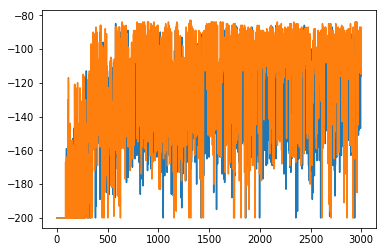

In [10]:
plt.plot(rewardTracker)
plt.plot(rewardTracker2)
plt.show()

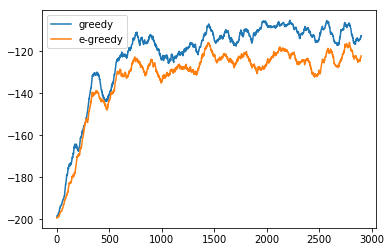

In [11]:
def smoothen(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

plt.plot(smoothen(rewardTracker2,100),label='greedy')
plt.plot(smoothen(rewardTracker,100),label='e-greedy')

plt.legend()
plt.show()

tiles_rew = rewardTracker2

Just to be sure of the benefits of the approach, let's compare learning performance without FA on a single grid. To do a fair comparison, we will use approximately the same ammount of parameters, so 1 tile of 40x40, that is, 1.600 parameters

In [12]:
tile = Tilecoder(1,40)
theta = np.random.uniform(-0.001, 0, size=(tile.n))
alpha = 0.05
gamma = 1
numEpisodes = 3000
rewardTracker = []
rewardTracker2 = []
episodeSum = 0
counter = 0 
epsilon = 0.05

for episodeNum in range(1,numEpisodes+1):
    G = 0
    state = env.reset()
    while True:
        #env.render()
        F = tile.getFeatures(state)
        Q = tile.getQ(F, theta)
        action = e_greedy_policy(Q)
        #action = np.argmax(Q)
        Qs = Q[action]
        state2, reward, done, info = env.step(action)
        G += reward
        if done == True:
            theta += np.multiply((alpha*(reward - Qs)), tile.oneHotVector(F,action))
            episodeSum += G
            rewardTracker.append(G)
            rewardTracker2.append(rollout(1))
            if episodeNum %200 == 0:
                print('Average reward = {}'.format(episodeSum / 200))
                #rewardTracker.append(episodeSum/ 100)  
                episodeSum = 0
            break
        Q = tile.getQ(tile.getFeatures(state2), theta)
        theta += np.multiply((alpha*(reward - Qs+gamma*np.max(Q))), tile.oneHotVector(F,action))
        state = state2

Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -200.0
Average reward = -199.835
Average reward = -199.995


No learning at all. Let's try to reduce the number of parameters to allow higher generalization

In [14]:
tile = Tilecoder(1,14)
theta = np.random.uniform(-0.001, 0, size=(tile.n))
alpha = 0.05
gamma = 1
numEpisodes = 3000
rewardTracker = []
rewardTracker2 = []
episodeSum = 0
counter = 0 
epsilon = 0.05

for episodeNum in range(1,numEpisodes+1):
    G = 0
    state = env.reset()
    while True:
        #env.render()
        F = tile.getFeatures(state)
        Q = tile.getQ(F, theta)
        action = e_greedy_policy(Q)
        #action = np.argmax(Q)
        Qs = Q[action]
        state2, reward, done, info = env.step(action)
        G += reward
        if done == True:
            theta += np.multiply((alpha*(reward - Qs)), tile.oneHotVector(F,action))
            episodeSum += G
            rewardTracker.append(G)
            rewardTracker2.append(rollout(1))
            if episodeNum %200 == 0:
                print('Average reward = {}'.format(episodeSum / 200))
                #rewardTracker.append(episodeSum/ 100)  
                episodeSum = 0
            break
        Q = tile.getQ(tile.getFeatures(state2), theta)
        theta += np.multiply((alpha*(reward - Qs+gamma*np.max(Q))), tile.oneHotVector(F,action))
        state = state2

Average reward = -200.0
Average reward = -199.7
Average reward = -198.73
Average reward = -197.785
Average reward = -197.905
Average reward = -194.21
Average reward = -192.71
Average reward = -178.28
Average reward = -191.21
Average reward = -184.51
Average reward = -177.005
Average reward = -181.715
Average reward = -176.215
Average reward = -164.04
Average reward = -157.57


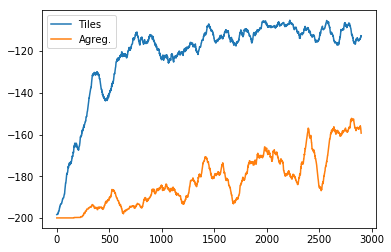

In [16]:
aggre_rew = rewardTracker2
plt.plot(smoothen(tiles_rew,100),label='Tiles')
plt.plot(smoothen(aggre_rew,100),label='Agreg.')
plt.legend()
plt.show()

## Exercises 

1. Try to find better parameters for agregation approach
2. Play with the parameters of Tiles
3. Use same approximation with Sarsa or MonteCarlo
4. **Try n-steps back-up**
5. Use other exploration strategies and play with functions reducing alpha and/or epsilon